---
# Descrição

- Este notebook mostra o desenvolvimento de uma rede neural simples com objetivo de fazer a predição dos valores das ações na abertura e fechamento para 30 dias futuros do preço de ações utilizando dados de 30 dias passados;
- Os dados obtidos foram extraídos da [Finance Yahoo](https://finance.yahoo.com/);
- Para o modelo de rede neural, foram utilizadas somente camadas simples (nn.Linear e nn.LeakyReLU);

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from random import random, choice

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

---
# Análise dataframe

In [2]:
df = pd.read_csv('PETR4.SA.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-20,16.02,16.020000,16.020000,16.020000,8.068292,0
1,2017-11-21,16.15,16.309999,15.850000,15.900000,8.007854,45817800
2,2017-11-22,16.09,16.240000,15.930000,16.110001,8.113620,37444900
3,2017-11-23,15.98,16.260000,15.940000,16.190001,8.153911,15403600
4,2017-11-24,16.25,16.370001,16.040001,16.100000,8.108582,18790700


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1240 entries, 0 to 1239
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1240 non-null   datetime64[ns]
 1   Open       1240 non-null   float64       
 2   High       1240 non-null   float64       
 3   Low        1240 non-null   float64       
 4   Close      1240 non-null   float64       
 5   Adj Close  1240 non-null   float64       
 6   Volume     1240 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 67.9 KB


---
# Separando dataset em treino-teste

In [4]:
df_train = df.iloc[:-30]
df_test = df.iloc[-30:]
print (f'df_train.shape: {df_train.shape}')
print (f'df_test.shape: {df_test.shape}')

df_train.shape: (1210, 7)
df_test.shape: (30, 7)


[]

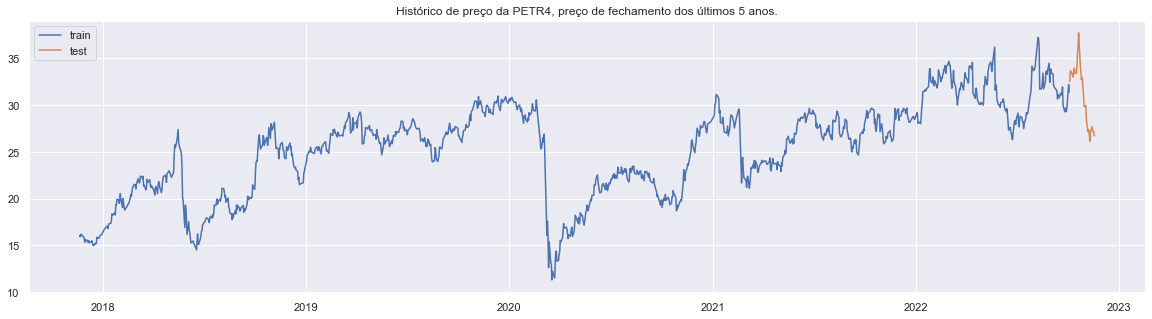

In [5]:
plt.figure(figsize=(20, 5))
plt.plot(df_train['Date'], df_train['Close'], label='train')
plt.plot(df_test['Date'], df_test['Close'], label='test')
plt.legend()
plt.title('Histórico de preço da PETR4, preço de fechamento dos últimos 5 anos.')
plt.plot()

---
# Classe Dataset

In [6]:
class Custom_Dataset(Dataset):

    def __init__(self, df_, future_days = 30, past_days = 15, colunas=['Close']):
        r"""
        - O dataset precisa ter as seguintes colunas: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'];
        - future_days representa o número de dias a prever;
        - past_days representa o número de dias passados usados para predição;
        - colunas representa as colunas que se desejam prever. Como default está sugerido somente ['Close']

        """
        df_ = df_.copy()
        self.future_days = future_days
        self.past_days = past_days
        
        df_['Date'] = pd.to_datetime(df_['Date'])
        df_.sort_values(by=['Date'], ascending=True, inplace=True)
        df_.set_index('Date', inplace=True)

        self.scaler = MinMaxScaler(feature_range=(-1, 1))
        self.df_ = self.scaler.fit_transform(df_)  # já é um vetor numpy

        input_tensor, target_tensor = [], []
        for k in range(self.past_days, len(self.df_)-self.future_days, 1):
            input_tensor.append(self.df_[k-self.past_days:k])
            target_tensor.append(self.df_[k:k+self.future_days])
        
        colunas = list(df_.columns.get_indexer_for(colunas))
        target_tensor = np.array(target_tensor)[...,colunas]

        dataset_len = len(input_tensor)

        self.input_tensor = torch.tensor(input_tensor, dtype=torch.float).reshape((dataset_len, -1))
        self.target_tensor = torch.tensor(target_tensor, dtype=torch.float).reshape((dataset_len, -1))

        self.input_len = self.input_tensor.shape[-1]   # número de neurônios para entrada da rede neural
        self.output_len = self.target_tensor.shape[-1] # número de neurônios para saída da rede neural

    def __len__(self):
        return len(self.input_tensor)
    
    def __getitem__(self, index):
        return self.input_tensor[index], self.target_tensor[index]

dataset = Custom_Dataset(df_train, future_days=30, past_days=30, colunas=['Open', 'Close'])
input_tensor, target_tensor = choice(dataset)

print (f'input_tensor.shape: {input_tensor.shape}')
print (f'target_tensor.shape: {target_tensor.shape}')

print (f'input_len: {dataset.input_len}')
print (f'output_len: {dataset.output_len}')

input_tensor.shape: torch.Size([180])
target_tensor.shape: torch.Size([60])
input_len: 180
output_len: 60


---
# Modelo

In [7]:
def create_model(inputs, outputs):
    return nn.Sequential(
        nn.Linear(in_features=inputs, out_features=256),
        nn.LeakyReLU(),
        nn.Linear(in_features=256, out_features=512),
        nn.LeakyReLU(),
        nn.Linear(in_features=512, out_features=256),
        nn.LeakyReLU(),
        nn.Linear(in_features=256, out_features=outputs)
    )

model = create_model(dataset.input_len, dataset.output_len)
model

Sequential(
  (0): Linear(in_features=180, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=256, out_features=512, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=256, out_features=60, bias=True)
)

---
# Treinamento

In [8]:
EPOCHS = 500
BATCH_SIZE = 16
LEARNING_RATE = 5e-4

PAST_DAYS = 15
FUTURE_DAYS = 30

dataset = Custom_Dataset(df_train, future_days=FUTURE_DAYS, past_days=PAST_DAYS, colunas=['Open', 'Close'])
train_dataset, test_dataset = train_test_split(dataset, test_size=0.1)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = create_model(inputs=dataset.input_len, outputs=dataset.output_len)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.8)

titles = ['epoch', 'train_loss', 'test_loss']
print (' | '.join([str(t).center(25) for t in titles]))

results = []

for epoch in range(EPOCHS):

    train_loss, test_loss = 0, 0

    model.train()
    for input_tensor, target_tensor in train_dataloader:
        optimizer.zero_grad()
        predict_tensor = model(input_tensor)
        loss = loss_fn(predict_tensor, target_tensor)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    model.eval()
    for input_tensor, target_tensor in test_dataloader:
        predict_tensor = model(input_tensor)
        loss = loss_fn(predict_tensor, target_tensor)
        
        test_loss += loss.item()
    
    vetor = [epoch, train_loss, test_loss]
    results.append(vetor)
    
    scheduler.step()

    if (epoch % 50 == 0):
        print (' | '.join([str(round(v,3)).center(25) for v in vetor]))

          epoch           |         train_loss        |         test_loss        
            0             |           3.707           |           0.371          
            50            |           0.872           |           0.182          
           100            |           0.407           |           0.105          
           150            |           0.161           |           0.072          
           200            |           0.145           |           0.077          
           250            |           0.088           |           0.094          
           300            |           0.064           |           0.054          
           350            |           0.045           |           0.062          
           400            |           0.056           |           0.067          
           450            |           0.035           |           0.057          


---
# Visualizando resultado treinamento

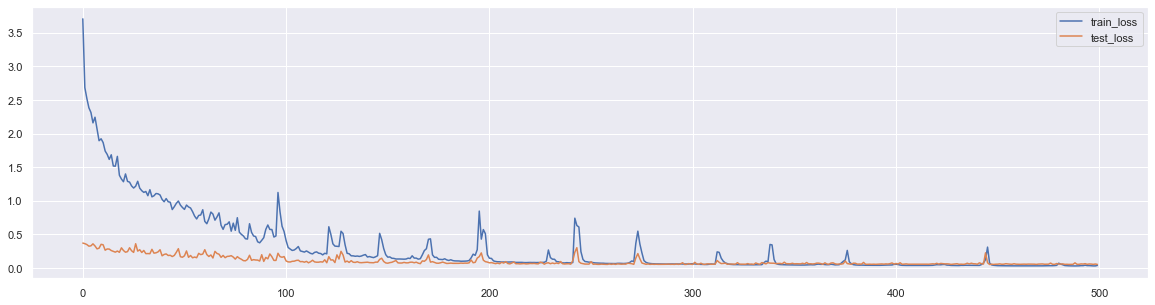

In [9]:
results = np.array(results)
plt.figure(figsize=(20, 5))
plt.plot(results[:,0], results[:,1], label='train_loss')
plt.plot(results[:,0], results[:,2], label='test_loss')
plt.legend()
plt.show()

---
# Comparando com valores reais

In [10]:
colunas_test = list(df_test.columns)

real_values = df_test[['Open', 'Close']].values # pegam somente os valores

input_tensor, target_tensor = dataset[-1] # pega o último dia do dataset de treinamento
predict_tensor = model(input_tensor)
predict_tensor = predict_tensor.reshape((dataset.future_days, 2)).detach().numpy()

# inserindo umas colunas zeradas apenas para utilizar inv_transformer do scaler dentro do objeto dataset
df_result = pd.DataFrame({
    'Open': predict_tensor[:,0],
    'High': np.zeros(len(predict_tensor)), 'Low': np.zeros(len(predict_tensor)),
    'Close': predict_tensor[:,1],
    'Adj Close': np.zeros(len(predict_tensor)), 'Volume': np.zeros(len(predict_tensor)),
}).values

# realizando o inv_transformer
predict_tensor = dataset.scaler.inverse_transform(df_result)[:,[0,3]]

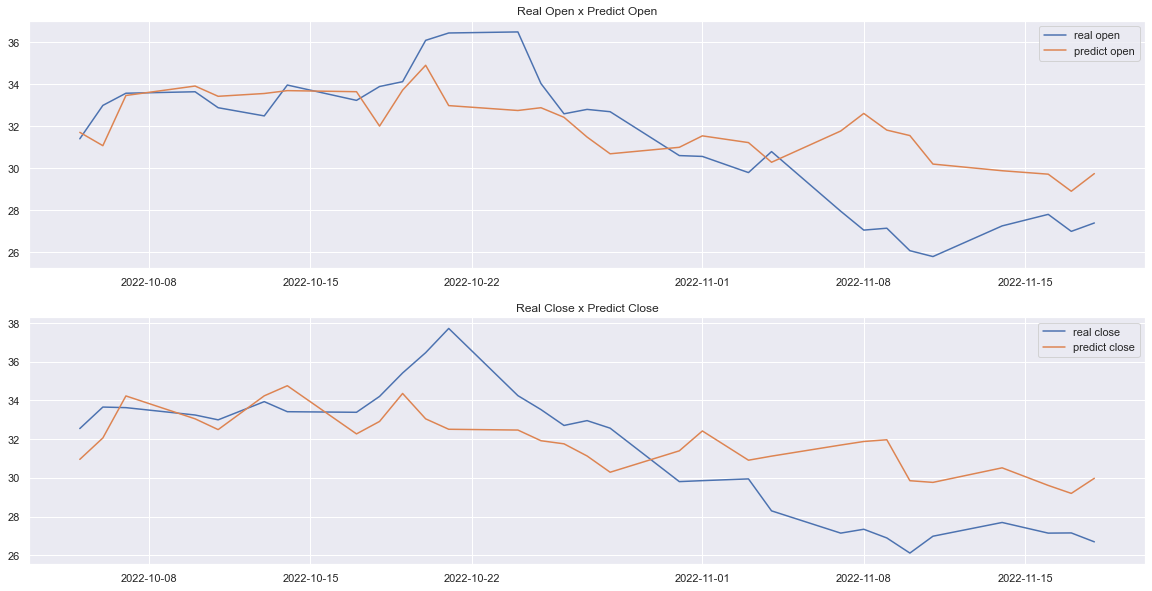

In [12]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
plt.plot(df_test['Date'], real_values[:,0], label='real open')
plt.plot(df_test['Date'], predict_tensor[:,0], label='predict open')
plt.title('Real Open x Predict Open')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df_test['Date'], real_values[:,1], label='real close')
plt.plot(df_test['Date'], predict_tensor[:,1], label='predict close')
plt.title('Real Close x Predict Close')
plt.legend()

plt.show()